# 4. 신경망 학습

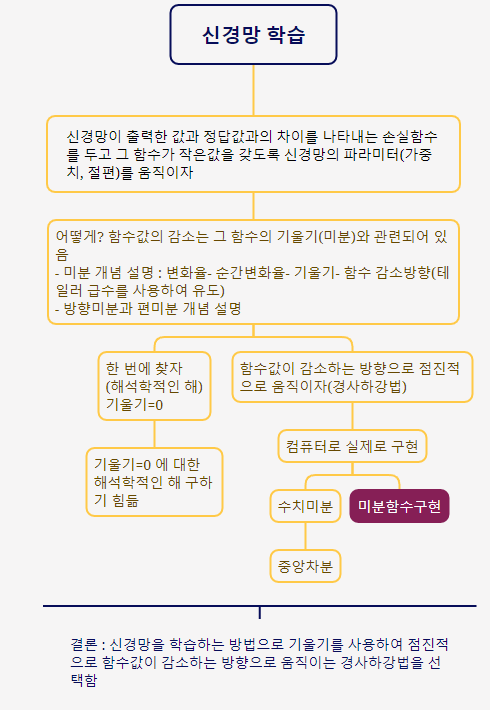

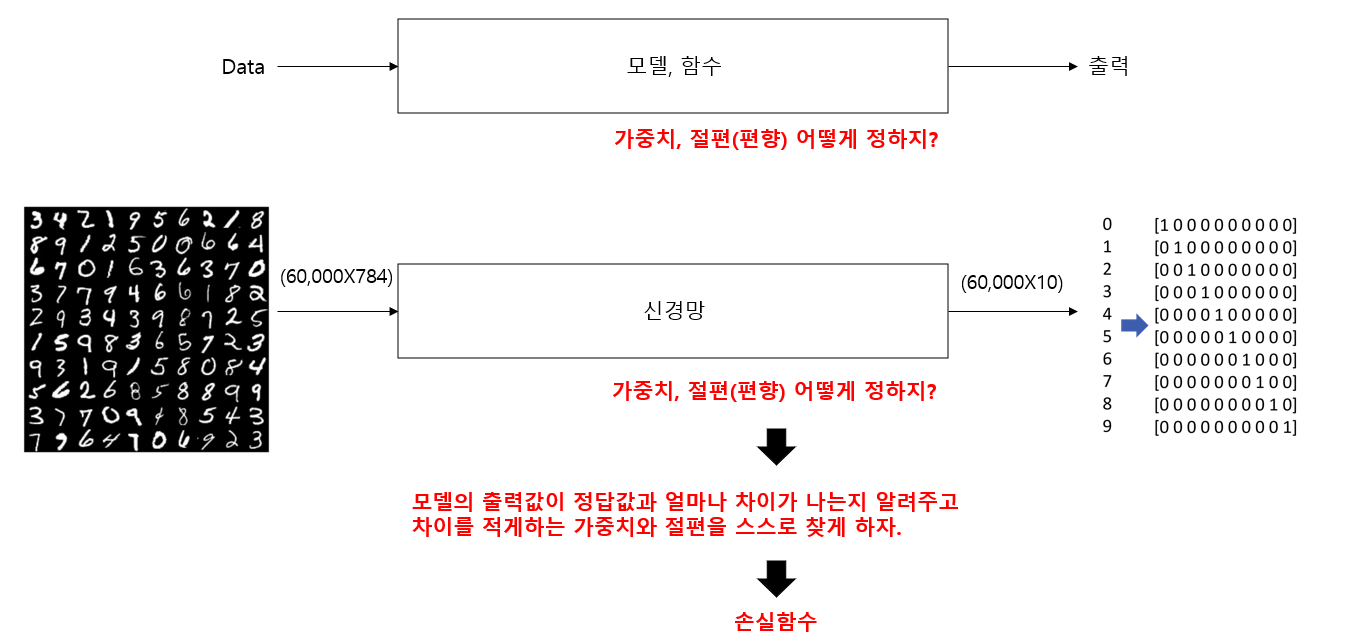

## 4.1. 데이터로부터 학습

### 4.1.1. 데이터 주도 학습

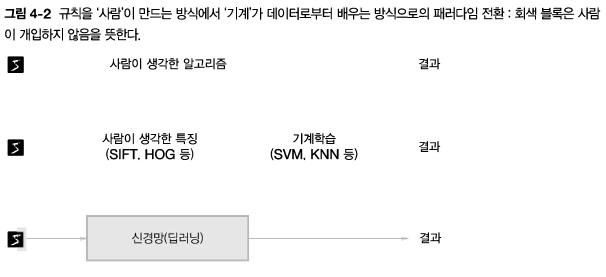

- 앞서배운 퍼셉트론은 사람의 논리를 기반으로 직접 규칙을 코딩한 것임.   
- 신경망은 그러한 문제의 패턴을 데이터로부터 스스로 학습하게끔 한다는 철학을 가지고 있음.

### 4.1.2. 훈련 데이터(Training data)와 시험 데이터(Test data) - 큰 맥락에서 일단 제외

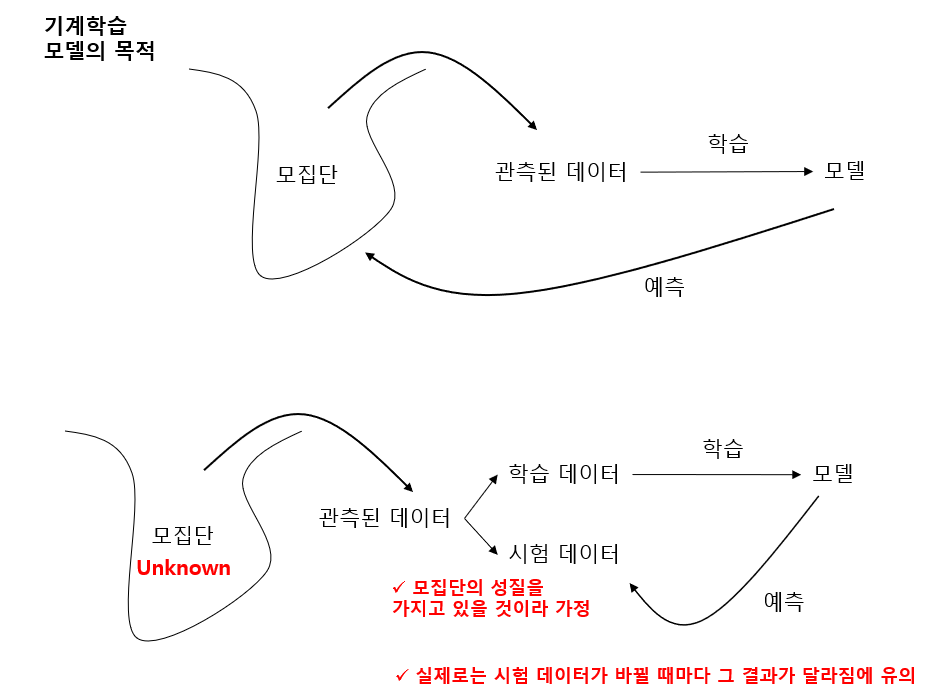

## 4.2. 손실함수(Loss function)

### 4.2.1. 평균 제곱 오차(Mean squared error) MSE

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1 ,0.0, 0.1, 0.0, 0.0])
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

- 예측 y가 2가 높다고 예측한 경우

In [4]:
print(mean_squared_error(y,t))

0.09750000000000003


- 예측 y가 7이 높다고 예측한 경우

In [5]:
y = np.array([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]) # 7이 높다고 추정한 경우
print(mean_squared_error(y,t))

0.5975


### 4.2.2. 교차 엔트로피 오차(Cross entropy error) CEE

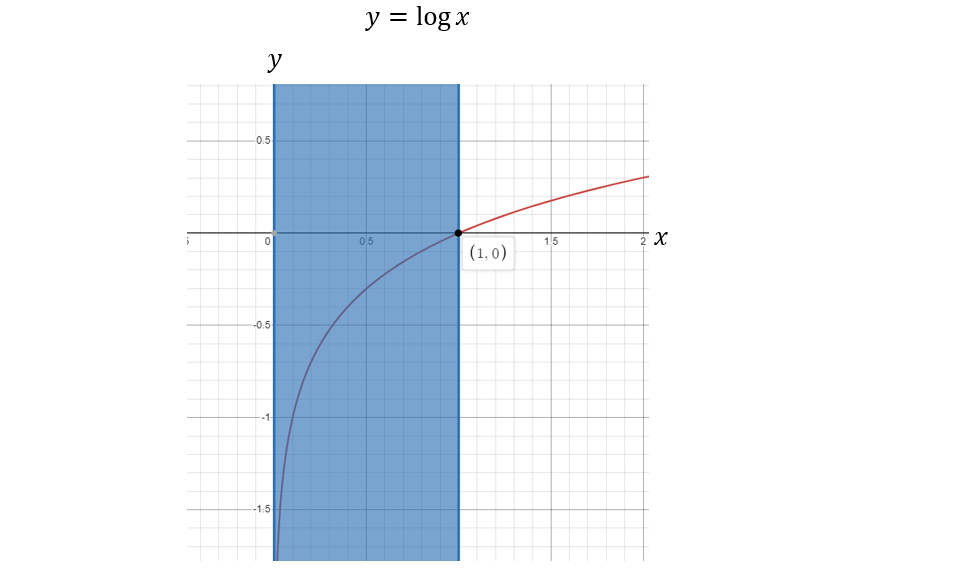

In [6]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [7]:
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1 ,0.0, 0.1, 0.0, 0.0])
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [8]:
print(cross_entropy_error(y,t))

0.510825457099338


In [9]:
y = np.array([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]) # 7이 높다고 추정한 경우
print(cross_entropy_error(y,t))

2.302584092994546


### 4.2.3. 미니배치 학습 - 큰 맥락에서 일단 제외

- 전체 데이터에 대한 손실함수를 최소화하는 대신 메모리 한계로 인해 전체 데이터 중 랜덤으로 일부를 선택하여 손실함수를 최소화하는 학습 방식임.

- 손실함수가 non-convex 함수로 복잡한 경우 local minimum 또는 saddle point를 벗어날 가능성이 있음.

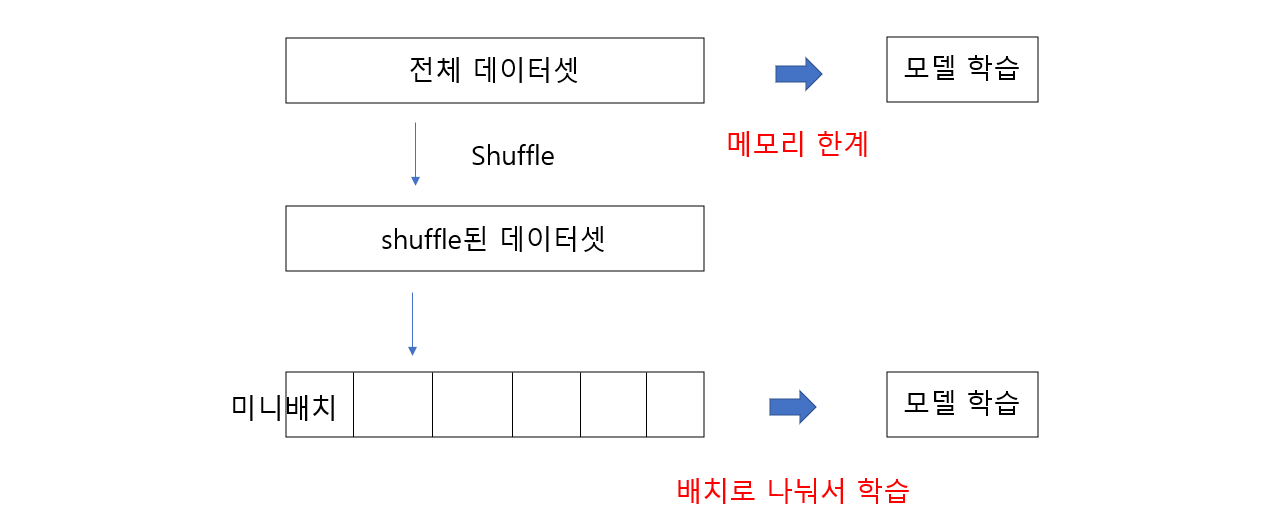

In [10]:
from tensorflow.keras.datasets import mnist
import os
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

print(np.shape(x_train))
print(np.shape(t_train))
print(np.shape(x_test))
print(np.shape(t_test))

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [11]:
train_size = x_train.shape[0]
print(train_size)

batch_size = 5
batch_mask = np.random.choice(train_size, batch_size)
print(batch_mask)

60000
[40477 54381 51931 58056 56133]


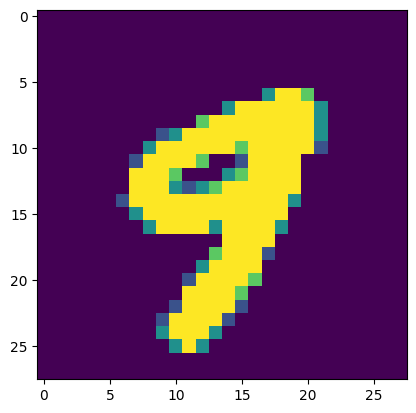

9


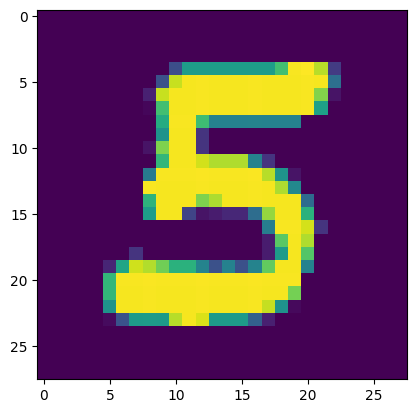

5


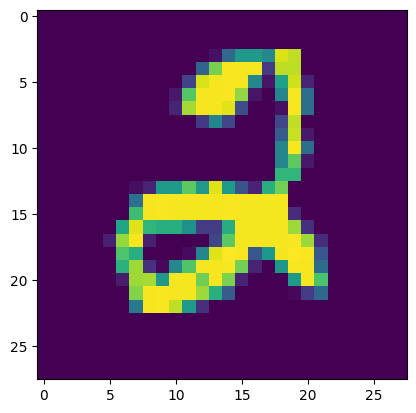

2


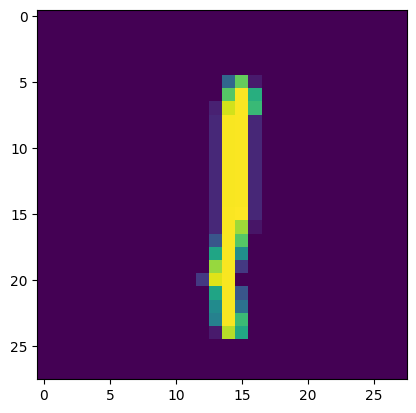

1


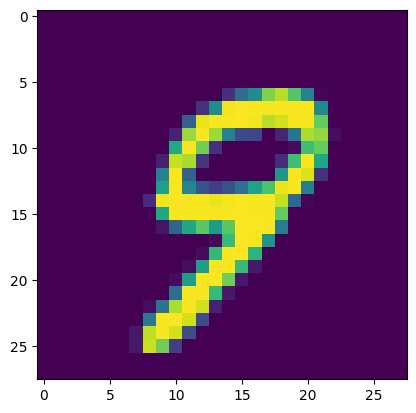

9


In [12]:
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

for i in range(len(x_batch)):
    plt.imshow(np.reshape(x_batch[i], (28, 28)))
    plt.show()
    print(t_batch[i])

### 4.2.4. (배치용) 교차 엔트로피 오차 구현

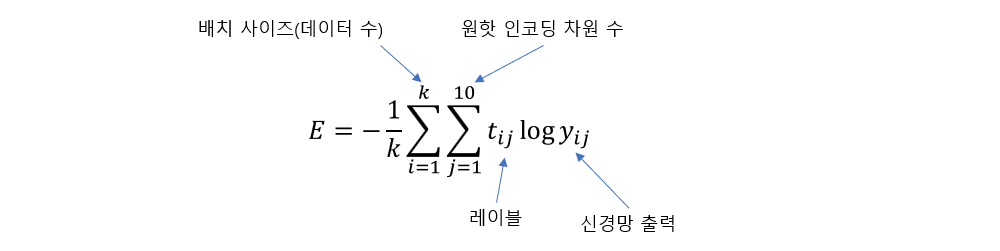

- k개의 batch_size에 대한 원핫인코딩된 cross entropy 값 구현

In [13]:
def cross_entropy_error(y, t):
    if y.ndim == 1: # 데이터가 1개인 경우를 의미함.
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

- 원핫 인코딩을 해주는 함수 구현

In [14]:
def one_hot_encode(t, num_classes):
    num_samples = t.shape[0]
    one_hot_labels = np.zeros((num_samples, num_classes))
    one_hot_labels[np.arange(num_samples), t] = 1
    return one_hot_labels

- t_batch를 원핫인코딩

In [15]:
print(t_batch)
t = one_hot_encode(t_batch, 10)
print(np.shape(t))
print(t)

[9 5 2 1 9]
(5, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


- 신경망의 출력을 원핫인코딩(여기서는 신경망을 아직 정의하지 않았으므로 임의의 랜덤 결과를 소프트맥스 값을 취한 결과를 원핫 인코딩함)   
- 아래 소프트맥스 함수는 배치사이즈만큼의 원핫인코딩 데이터를 처리하는 함수로 구현함

In [16]:
def softmax(a):
    c = np.max(a, axis=1) # a가 (batch size x 원핫인코딩 차원 수) 인 경우 행 방향으로 가장 큰 값을 뺌(수치 안정화 위해)
    c = np.reshape(c, (-1,1)) # 브로드캐스트 연산 지원을 위해 shape 변경
    r = a - c
    exp_a = np.exp(r)
    
    sum_exp_a = np.sum(exp_a, axis=1)
    sum_exp_a = np.reshape(sum_exp_a, (-1,1))
    y = exp_a / sum_exp_a
    return y

In [17]:
y = np.random.randn(5,10)
y = softmax(y)
print(np.shape(y))
print(y)

(5, 10)
[[0.06843837 0.03372257 0.01491268 0.04359002 0.11828398 0.13475166
  0.08769299 0.03874727 0.34871659 0.11114385]
 [0.13022186 0.03011803 0.08846531 0.04385519 0.05202936 0.05584271
  0.09842373 0.31727194 0.10995135 0.07382052]
 [0.04697561 0.33952518 0.07037648 0.28029824 0.02528942 0.03880073
  0.00657436 0.01426819 0.03522934 0.14266244]
 [0.08017794 0.03180783 0.12786113 0.10637054 0.01071256 0.14720644
  0.25540603 0.0651833  0.0826924  0.09258183]
 [0.10575686 0.02622443 0.12598682 0.16494442 0.15448261 0.0192297
  0.25592932 0.08233995 0.03287441 0.03223149]]


- batch size로 원핫인코딩된 y, t의 cross entropy 값

In [18]:
print(cross_entropy_error(y,t))

2.923777285785728


- (batch size X 원핫인코딩 차원 수) 를 입력으로 받는 소프트맥스 구현 step

In [19]:
y = np.random.randn(5,10)

c = np.max(y, axis=1)
print(np.shape(c))

(5,)


In [20]:
c = np.reshape(c, (-1,1)) # 브로드캐스트 연산 지원을 위해 shape 변경
print(np.shape(c))

r = y - c
print(np.shape(r))
exp_a = np.exp(r)
print(np.shape(exp_a))

(5, 1)
(5, 10)
(5, 10)


In [21]:
sum_exp_a = np.sum(exp_a, axis=1)
print(np.shape(sum_exp_a))

sum_exp_a = np.reshape(sum_exp_a, (-1,1))
print(np.shape(sum_exp_a))

y = exp_a / sum_exp_a
print(np.shape(y))
print(np.sum(y, axis=1))

(5,)
(5, 1)
(5, 10)
[1. 1. 1. 1. 1.]


### 4.2.5. 왜 손실함수를 설정하는가?

- 모델 안에 있는 파라미터(가중치와 절편)들을 조정함으로써 데이터가 입력되었을 때 올바른 출력을 하기 위함.   
- 이때 올바른 출력을 알려주기 위해 모델의 출력과 정답값과의 차이를 알려주는 손실함수를 도입함.   
- 파라미터는 손실함수가 줄어드는 방향으로 학습되길 원함.

- 손실함수를 설정하였으므로 이제 손실함수가 작은 값을 갖게하는 방향으로 찾아가는 방법에 대해 알아봄

## 4.3. 수치 미분

- 결론 : 신경망 학습을 위해 결론적으로 미분 함수로 표현된 것을 사용할 것임. 수치 미분 사용 X

### 4.3.1. 미분(순간변화율)

- 순간변화율에서 h는 0은 아니지만 0에 매우 가까운 값을 의미함.   
- 그러므로 h를 컴퓨터로 표현할 수 있는 작은 수인 10e-50 (소수점이 50개가 붙어있는 10을 의미함. = 0.0000000...001) 

In [22]:
# 나쁜 구현 예
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

- 10e-50 값을 float32비트 형으로 출력해보면 메모리가 받아들이지 못해 0으로 출력함.

In [23]:
print( np.float32(10e-50))

0.0


- 만약 $f(x) = x^2$ 이라면 위와 같은 수치 미분의 구현 값은 다음과 같이 출력됨   
- 참고로 $x^2$ 함수에 대한 미분은 $2x$임.

In [24]:
x = 2

def f(x):
    return x**2

numerical_diff(f=f, x=x)

0.0

- 1e-50이 아닌 적당히 작은 값 1e-7 정도를 잡아 구현한다면

In [25]:
# 나쁜 구현 예
def numerical_diff(f, x):
    h = 1e-7
    return (f(x+h) - f(x)) / h

In [26]:
x = 2

def f(x):
    return x**2

numerical_diff(f=f, x=x)

4.000000091153311

- 다른 수치미분 방법인 중앙차분으로 구현

In [27]:
def numerical_diff(f, x):
    h = 1e-4 #0.001
    return ((f(x+h) - f(x-h) ) / (2*h) )

In [28]:
x = 2

def f(x):
    return x**2

numerical_diff(f=f, x=x)

4.000000000004

- 1e-7 보다 큰 값인 1e-4임에도 불구하고 좀 더 정교하게 값을 구하는 것을 볼 수 있음.

### 4.3.2. 수치 미분의 예

In [29]:
def function_1(x):
    return 0.01 * x**2 + 0.1*x

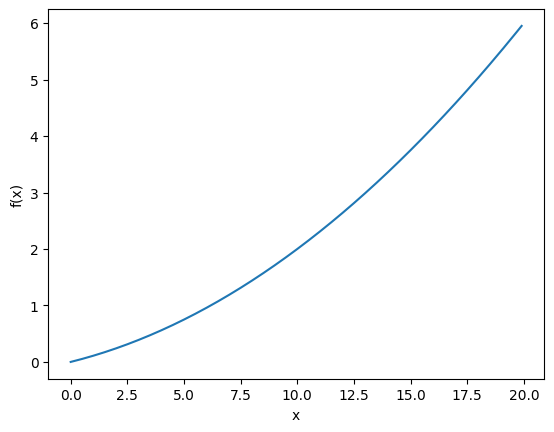

In [30]:
x = np.arange(0, 20, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel('f(x)')
plt.plot(x, y)
plt.show()

In [31]:
print(numerical_diff(f=function_1, x=5))

0.1999999999990898


In [32]:
print(numerical_diff(f=function_1, x=10))

0.2999999999986347


- 실제 미분 값은 $ \frac{d f(x)} {d x} = 0.02x + 0.1 $ 이며 $x=5$ 인 경우는 0.2 이고 $x=10$ 인 경우는 0.3 임.   
- 정확한 값을 구한 것은 아니지만 꽤 가까운 근사치를 구한 것을 확인할 수 있음.   
- 또한 수치 미분을 구현해놓음으로써 f 라는 매개변수에 어떤 함수든지 넣으면 미분 근사함수를 구해준다는 편리성을 얻을 수 있음.

- 나중에 우리는 어떤 함수의 수치미분을 사용하는 것이 아니라 미분 함수를 그냥 함수식으로 구현하여 아래와 같이 사용할 것임.

In [33]:
def diff_function_1(x):
    return 0.02*x + 0.1

In [34]:
print(diff_function_1(x=5))
print(diff_function_1(x=10))

0.2
0.30000000000000004


# 
### 핵심 질문 : 움직여야할 파라미터가 여러 개이면 손실함수가 작아지는 방향으로 어떻게 움직여야 하는가?

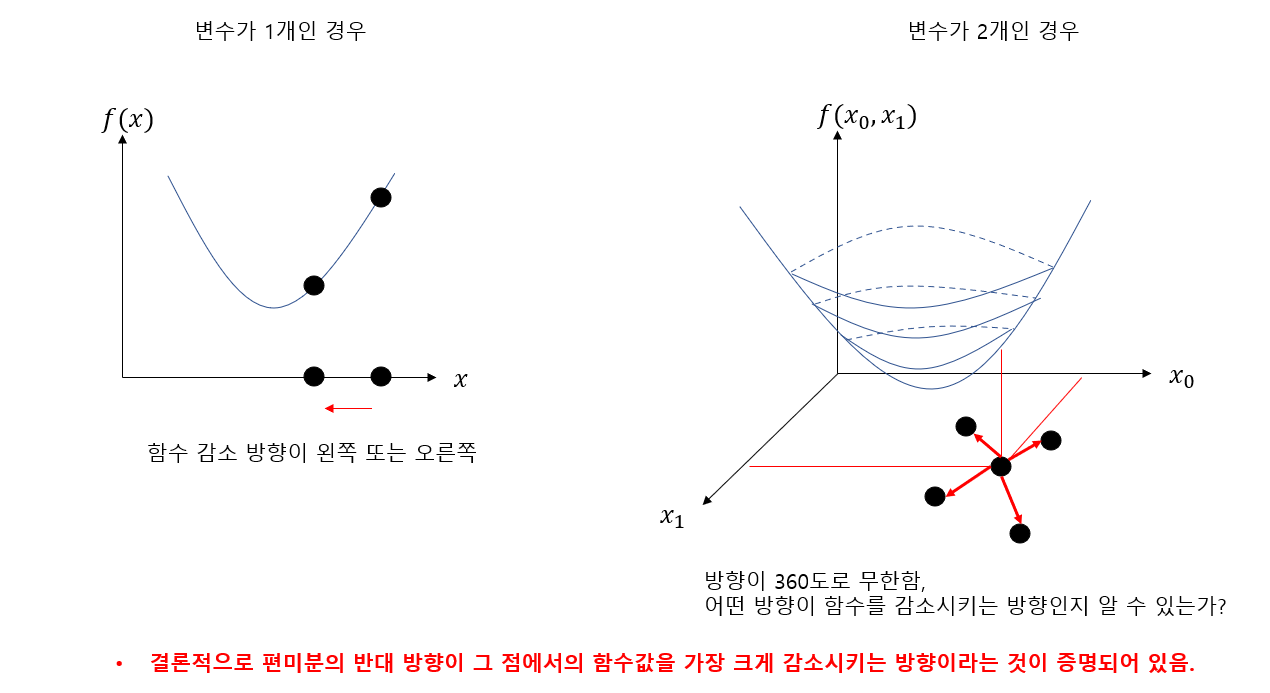

### 4.3.3. 편미분

- $f(x_{0}, x_{1})=x_{0}^{2} + x_{1}^{2}$

In [35]:
def function_2(x): # x 매개변수는 array 배열 형태로 받을 것임.
    return x[0]**2 + x[1]**2

In [36]:
%matplotlib notebook

<IPython.core.display.Javascript object>


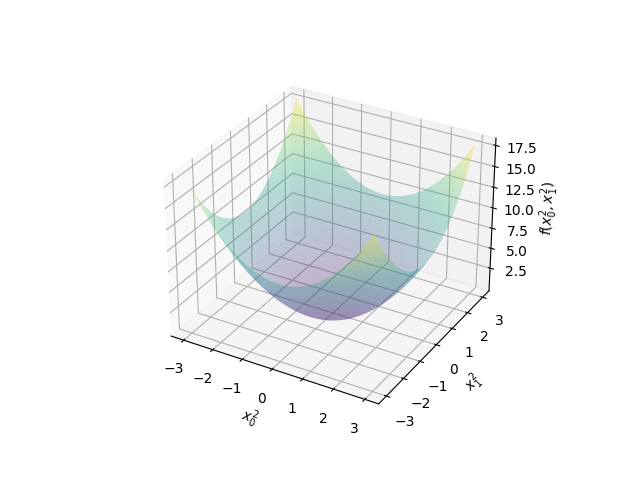

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


x_range = np.linspace(-3, 3, 100)  # -3부터 3까지 100개의 점을 생성

# 2차원 그리드 생성
X, Y = np.meshgrid(x_range, x_range)

# 함수 값을 계산하여 Z 값 생성
Z = function_2([X, Y])  # z 값도 f(x_0^2, x_1^2)로 설정

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 3차원 그래프에 표시
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3)

# 축 레이블 추가
ax.set_xlabel('$x_0^2$')
ax.set_ylabel('$x_1^2$')
ax.set_zlabel('$f(x_0^2, x_1^2)$')

# 그래프 표시
plt.show()

- 편미분이란 두 개 이상의 파라미터에 대한 함수에 대해 특정한 방향으로 미분을 하는 방법으로써   
- 각 파라미터들에 대해 함수를 미분하려고 할 때, 나머지 파라미터들을 상수로 고정시켜놓고 미분하는 방법임.

- 편미분 예제:
1. $x_{0}=3, x_{1}=4$ 일 때, $x_{0}$ 에 대한 편미분 $ \frac {\partial{f}} {\partial{x_{0}}}$ 을 구하라.
- 위 함수에서 $x_{1}=4$ 를 대입한 함수를 풀이하면됨.

In [38]:
def function_tmp1(x0):
    return x0*x0 + 4**2

In [39]:
print(numerical_diff(f=function_tmp1, x=3))

6.00000000000378


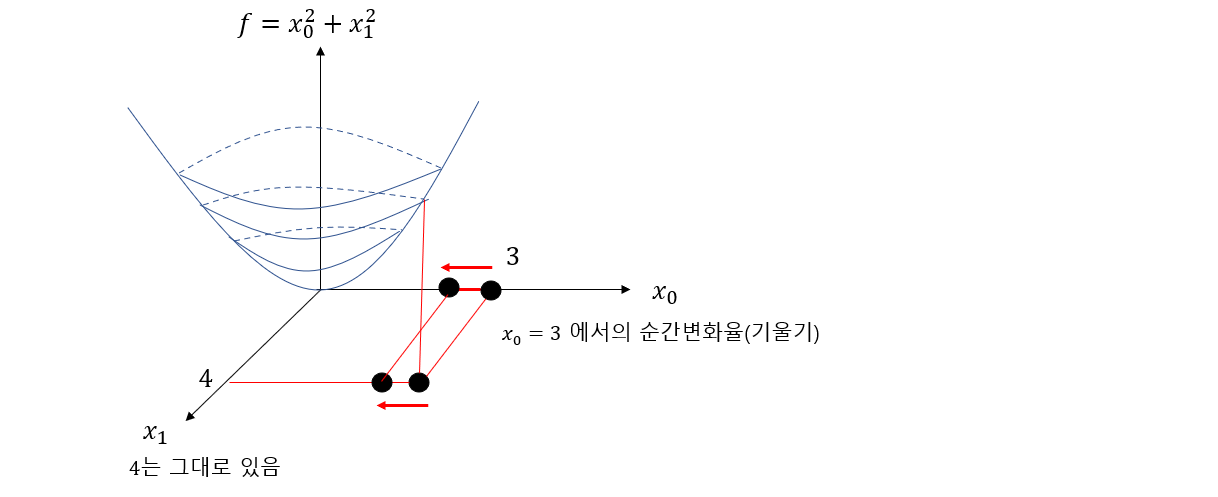

2. $x_{0}=3, x_{1}=4$ 일 때, $x_{1}$ 에 대한 편미분 $ \frac {\partial{f}} {\partial{x_{1}}}$ 을 구하라.

In [40]:
def function_tmp2(x1):
    return 3**2 + x1*x1

In [41]:
print(numerical_diff(f=function_tmp2, x=4))

7.999999999999119


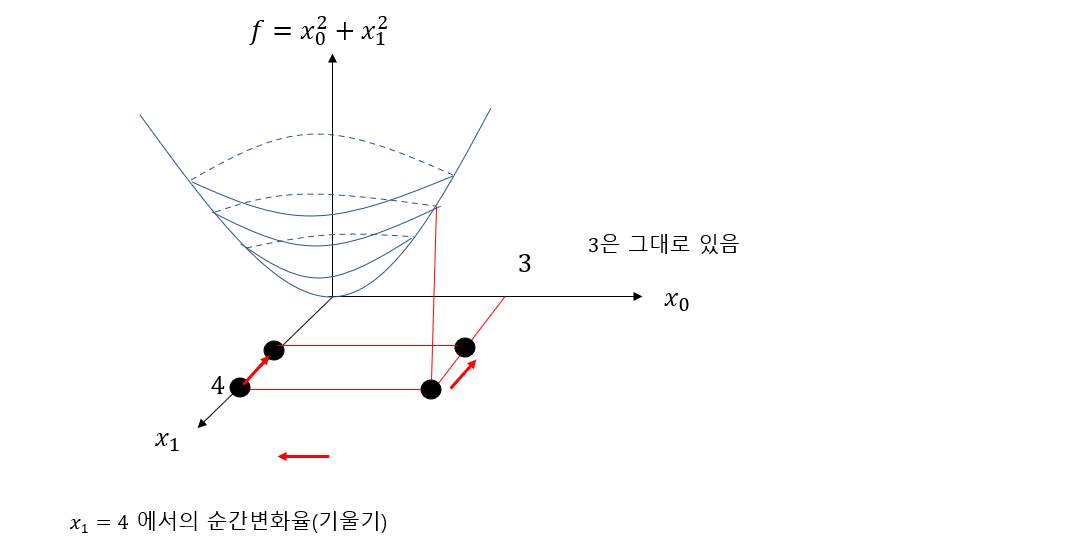

## 4.4. 기울기 Gradient

- Gradient는 편미분을 벡터로 표현한 것임.

gradient = ($ \frac{\partial{f}} {\partial{ x_{0}}}, \frac{\partial{f}} {\partial{x_{1}}} $)

In [42]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h) # 중앙차분
        x[idx] = tmp_val # 값 복원
    return grad

In [43]:
print(numerical_gradient(function_2, np.array([3.0,4.0])))

[6. 8.]


In [44]:
print(numerical_gradient(function_2, np.array([0.0,2.0])))

[0. 4.]


### 4.3.1. 경사하강법 Gradient descent

$ x_{0} = x_{0}-\eta \frac {\partial{f}} {\partial{x_{0}}} $

$ x_{1} = x_{1}-\eta \frac {\partial{f}} {\partial{x_{1}}} $

$\eta$ : 학습률 (일반적으로 0.01, 0.001 등을 사용)

In [45]:
def gradient_descent(f, init_x, lr=0.01, step_num=1000):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

- 문제 : 경사하강법으로 $f(x_{0}, x_{1})=x_{0}^{2} + x_{1}^{2}$ 의 최소값 구하기

In [46]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [47]:
init_x = np.array([-3.0, 4.0])
x = gradient_descent(f=function_2, init_x=init_x)

print(x)

[-5.04890207e-09  6.73186943e-09]


In [48]:
x = np.array(x)
print(function_2(x))

7.080947813623988e-17


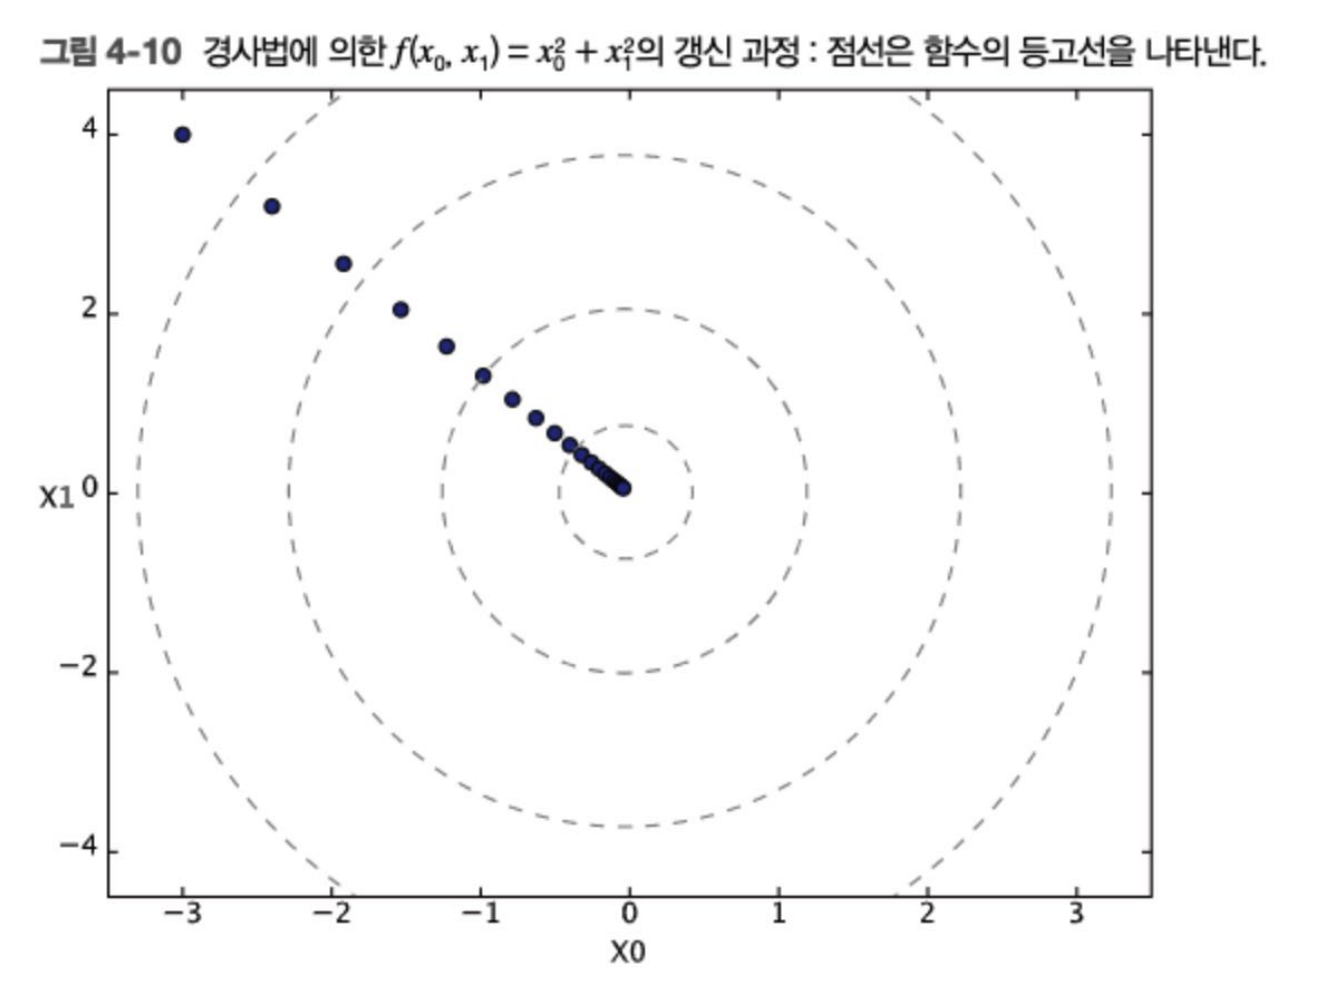

In [49]:
# 학습률이 너무 큰 예 : 발산 lr=10
init_x = np.array([3.0, 4.0])
x = gradient_descent(function_2, init_x, 10.0, 1000)
print(x)

x = np.array(x)
print(function_2(x))

[ 2.58983747e+13 -1.29524862e+12]
6.724034830146604e+26


In [50]:
# 학습률이 너무 작은 예 : lr=1e-10
init_x = np.array([3.0, 4.0])
x = gradient_descent(function_2, init_x, 1e-10, 1000)
print(x)

x = np.array(x)
print(function_2(x))

[2.9999994 3.9999992]
24.99999000000026


- 적절한 학습률 설정이 중요함

#### 결론적으로는 수치미분이 아닌 함수의 각 편미분 함수를 구하여 계산하면 정확한 결과를 얻어낼 수 있음.
#### 아래와 같은 방법이 신경망에서 실제로 사용하는 경사하강법임.

- 손실함수 예: - $L(x_{0}, x_{1})=x_{0}^{2} + x_{1}^{2}$

In [51]:
def Loss_function(x):
    return x[0]**2 + x[1]**2

- 편미분

In [52]:
def diff_Loss_x1(x):
    return 2*x[0]

def diff_Loss_x2(x):
    return 2*x[1]

0 th 손실함수 값 : 24.900100000000002
100 th 손실함수 값 : 16.684352187233166
200 th 손실함수 값 : 11.17937710722576
300 th 손실함수 값 : 7.490759671280297
400 th 손실함수 값 : 5.019195605863568
500 th 손실함수 값 : 3.3631201153746755
600 th 손실함수 값 : 2.2534640605009324
700 th 손실함수 값 : 1.5099372302388363
800 th 손실함수 값 : 1.0117358777643504
900 th 손실함수 값 : 0.6779152575724555
1000 th 손실함수 값 : 0.45423821231391565
1100 th 손실함수 값 : 0.3043630471823233
1200 th 손실함수 값 : 0.20393895092667663
1300 th 손실함수 값 : 0.13664962317241813
1400 th 손실함수 값 : 0.09156230052334427
1500 th 손실함수 값 : 0.06135146722321429
1600 th 손실함수 값 : 0.04110864961809789
1700 th 손실함수 값 : 0.027544917015189203
1800 th 손실함수 값 : 0.018456516096301934
1900 th 손실함수 값 : 0.012366818394305226
2000 th 손실함수 값 : 0.008286406621906814
2100 th 손실함수 값 : 0.005552320129096445
2200 th 손실함수 값 : 0.003720341062490069
2300 th 손실함수 값 : 0.0024928205325765564
2400 th 손실함수 값 : 0.0016703184206116996
2500 th 손실함수 값 : 0.0011191995531868808
2600 th 손실함수 값 : 0.0007499214667075192
2700 th 손실함수 

<IPython.core.display.Javascript object>


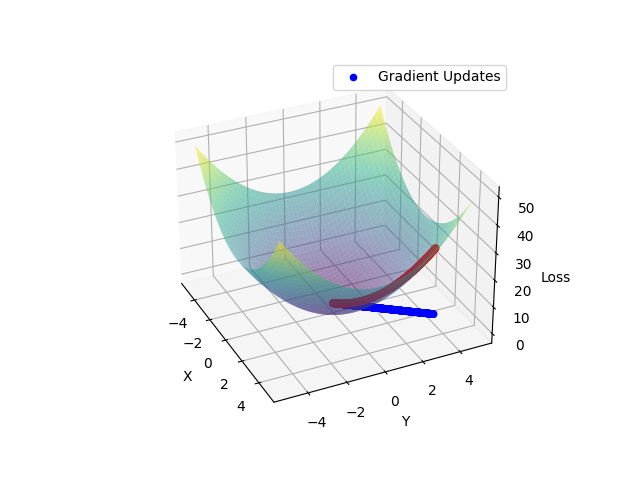

In [54]:
init_x = np.array([3.0 , 4.0])

lr = 0.001

# Lists to store points for plotting
x_vals = []
y_vals = []
z_vals = []

for i in range(3000):
    x_vals.append(init_x[0])
    y_vals.append(init_x[1])
    z_vals.append(Loss_function(init_x))
    
    dx1 = diff_Loss_x1(init_x)
    dx2 = diff_Loss_x2(init_x)
    dx = np.array([dx1, dx2])
    
    init_x = init_x - lr * dx
    
    if i % 100 == 0:
        print("{} th 손실함수 값 : {}".format(i, Loss_function(init_x)))

# Plotting the loss function surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = Loss_function([X, Y])

ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Loss')

zero_values = np.zeros_like(z_vals)
# Plotting the gradient updates
ax.scatter(x_vals, y_vals, z_vals, color='red')
ax.scatter(x_vals, y_vals, zero_values, color='blue', label='Gradient Updates')
ax.legend()

plt.show()